<a href="https://colab.research.google.com/github/DilemmaFixer3/AI_labs/blob/main/lab_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Random Seed: 999
Використовується пристрій: cuda:0


100%|██████████| 9.91M/9.91M [00:00<00:00, 58.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 18.2MB/s]


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTrans

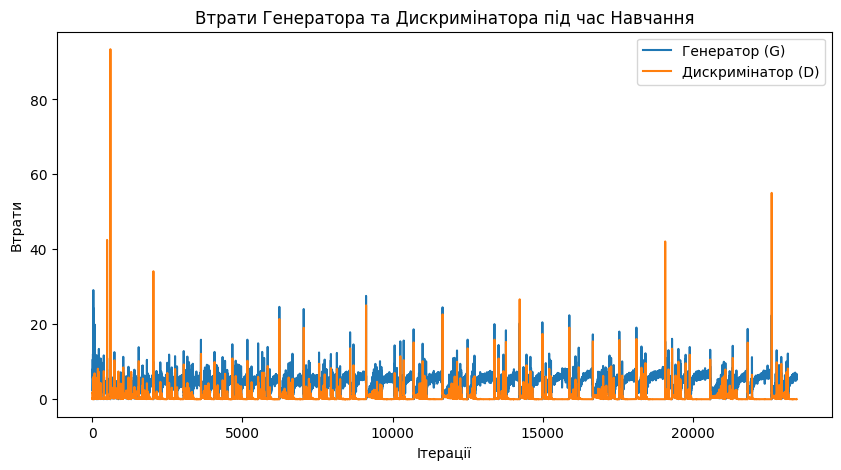

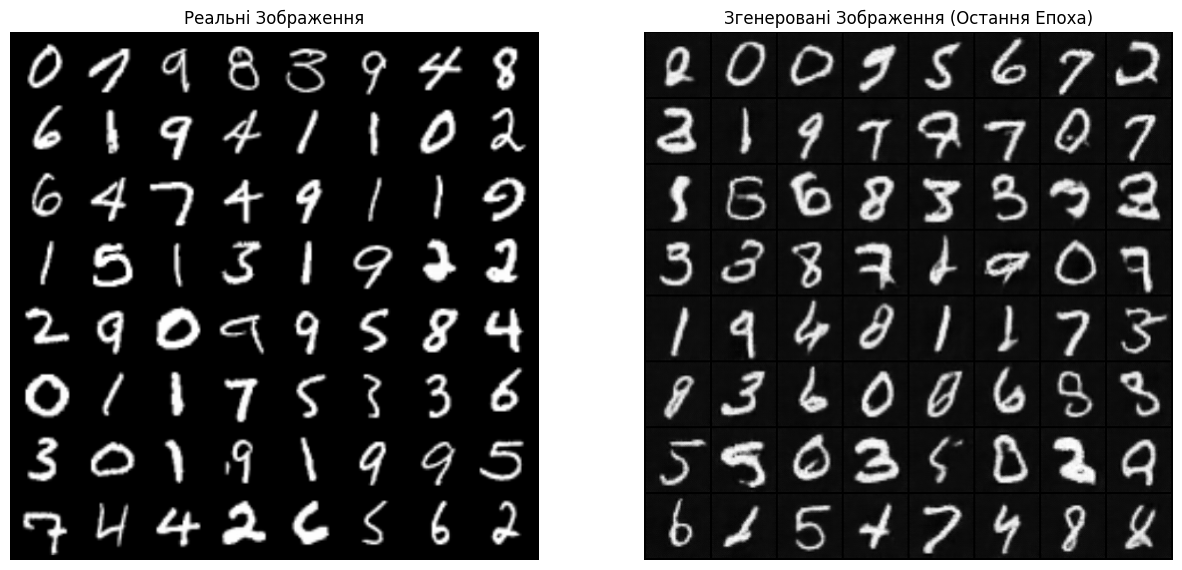


АНАЛІЗ ЯКОСТІ ГЕНЕРАЦІЇ ТА ВИСНОВКИ

4. Візуальна оцінка якості:
   - Після 50-100 епох згенеровані зображення повинні візуально нагадувати рукописні цифри MNIST.
   - Добре навчена модель генерує чіткі, добре сформовані '0', '1', '6', '7', '8' і менш чіткі '3', '5', '9' (залежно від навчання).

6. Аналіз та обговорення проблем:
   - **Якість Генерації:** Якщо навчання пройшло успішно, згенеровані цифри мають бути реалістичними, хоча можуть мати артефакти, типові для GAN (наприклад, нерівні краї або розмитість).
   - **Проблема 'Колапс мод' (Mode Collapse):** Ця проблема виникає, коли Генератор починає генерувати лише невелику підмножину можливих вихідних даних (наприклад, тільки цифри '1' і '0'). На графіках втрат це може проявлятися у великих коливаннях. Для виявлення необхідно переглянути згенеровані зображення і перевірити, чи представлені всі 10 класів цифр.
   - **Висновки щодо Аугментації:** Згенеровані зображення можуть бути використані для **аугментації даних** (Data Augmenta

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os

# Створення директорії для збереження результатів
os.makedirs("dcgan_mnist_results", exist_ok=True)

# ----------------------------------------------------------------------
# 2. Налаштування Гіперпараметрів та Пристрою
# ----------------------------------------------------------------------
# Рекомендовані налаштування
manualSeed = 999
print(f"Random Seed: {manualSeed}")
torch.manual_seed(manualSeed)

# Завантажувати підмножину (завдання 1 - 1-2 тис. зображень одного або кількох класів)
# Для простоти і кращої якості генерації, ми завантажимо весь датасет MNIST,
# але можна обмежити його, фільтруючи класи.
# В цьому прикладі завантажимо всі 10 класів.
dataroot = "data/mnist"
workers = 2 # Кількість потоків для завантаження даних
batch_size = 128 # Рекомендовано: 128
image_size = 64 # Рекомендовано: 64x64
nc = 1 # Кількість каналів вхідних зображень (1 для MNIST - чорно-білі)
nz = 100 # Розмір вектора шуму (вхід Генератора)
ngf = 64 # Кількість фітрів у Генераторі
ndf = 64 # Кількість фітрів у Дискримінаторі
num_epochs = 50 # Рекомендовано: 50–100

lr = 0.0002 # Рекомендовано: 0.0002
beta1 = 0.5 # Рекомендовано: 0.5

# Втрати: BinaryCrossentropy
criterion = nn.BCELoss()

# Пристрій (GPU, якщо доступно)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Використовується пристрій: {device}")


# ----------------------------------------------------------------------
# 3. Підготовка Даних (MNIST) - Завдання 1 та 2
# ----------------------------------------------------------------------
# Опис полів: Зображення (пікселі 0-255), Мітка (цифра 0-9).
# Тип даних: Зображення цифр.
# Датасет: MNIST.

# Перетворення: зміна розміру зображень (64x64), нормалізація до діапазону [-1, 1]
transform = transforms.Compose([
    transforms.Resize(image_size), # Зміна розміру зображень (напр., 64x64)
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), # Нормалізація до діапазону [-1, 1]
])

# Завантаження датасету
dataset = dset.MNIST(root=dataroot, train=True, download=True, transform=transform)

# Фільтрування (опціонально: для генерації тільки певних цифр)
# наприклад, для генерації тільки цифри '1':
# target_class = 1
# indices = [i for i, (_, label) in enumerate(dataset) if label == target_class]
# dataset = torch.utils.data.Subset(dataset, indices)
# print(f"Кількість зображень для класу '{target_class}': {len(dataset)}")

# Створення DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

# ----------------------------------------------------------------------
# Допоміжна функція для ініціалізації ваг
# ----------------------------------------------------------------------
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# ----------------------------------------------------------------------
# 4. Визначення Архітектури DCGAN - Завдання 3
# ----------------------------------------------------------------------

# Генератор: Conv2DTranspose, BatchNormalization, LeakyReLU
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Вхід: nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Розмір фіч: (ngf*8) x 4 x 4

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Розмір фіч: (ngf*4) x 8 x 8

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Розмір фіч: (ngf*2) x 16 x 16

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            # Розмір фіч: (ngf) x 32 x 32

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh() # Вихід: nc x 64 x 64, масштабування до [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

# Дискримінатор: Conv2D, LeakyReLU, Dropout
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Вхід: nc x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Розмір фіч: (ndf) x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2), # Додаємо Dropout
            # Розмір фіч: (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Розмір фіч: (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Розмір фіч: (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() # Вихід: 1 (бінарна класифікація)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


# ----------------------------------------------------------------------
# 5. Ініціалізація Моделей, Оптимізаторів та Функцій Втрат
# ----------------------------------------------------------------------
# Ініціалізація Генератора
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Ініціалізація Дискримінатора
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

# Оптимізатори: Adam з learning_rate=0.0002, beta_1=0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Фіксований вектор шуму для візуалізації прогресу генерації
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

# Змінні для збереження втрат
G_losses = []
D_losses = []
img_list = []
iters = 0


# ----------------------------------------------------------------------
# 6. Функція Навчання та Візуалізація - Завдання 3
# ----------------------------------------------------------------------
print("Починаємо навчання...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # ----------------------------------------------
        # (1) Оновлення Дискримінатора: Максимізація log(D(x)) + log(1 - D(G(z)))
        # ----------------------------------------------
        ## Навчання на реальних зображеннях
        netD.zero_grad()
        # Форматування пакету даних
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Прохід Дискримінатора через реальні дані
        output = netD(real_cpu).view(-1)
        # Обчислення втрат для реальних даних
        errD_real = criterion(output, label)
        # Зворотне поширення
        errD_real.backward()
        D_x = output.mean().item()

        ## Навчання на згенерованих (фейкових) зображеннях
        # Генерація фейкових зображень
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        # Прохід Дискримінатора через фейкові дані
        output = netD(fake.detach()).view(-1)
        # Обчислення втрат для фейкових даних
        errD_fake = criterion(output, label)
        # Зворотне поширення
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Сумарні втрати Дискримінатора та оновлення ваг
        errD = errD_real + errD_fake
        optimizerD.step()

        # ----------------------------------------------
        # (2) Оновлення Генератора: Максимізація log(D(G(z)))
        # ----------------------------------------------
        netG.zero_grad()
        label.fill_(real_label)  # Фейкові мітки "реальних" для Генератора

        # Прохід Дискримінатора через фейкові дані (без detach)
        output = netD(fake).view(-1)
        # Обчислення втрат Генератора
        errG = criterion(output, label)
        # Зворотне поширення та оновлення ваг
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Виведення статистики
        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # Збереження втрат для графіків
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Збереження згенерованих зображень (Завдання 5: Візуалізації)
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            # Збереження зображення
            vutils.save_image(
                vutils.make_grid(fake, padding=2, normalize=True),
                f'dcgan_mnist_results/epoch_{epoch:03d}.png',
                normalize=True
            )

        iters += 1

# ----------------------------------------------------------------------
# 7. Запуск Навчання та Аналіз Результатів - Завдання 5 та 6
# ----------------------------------------------------------------------

## Візуалізація Графіків Втрат (Завдання 5)
plt.figure(figsize=(10,5))
plt.title("Втрати Генератора та Дискримінатора під час Навчання")
plt.plot(G_losses, label="Генератор (G)")
plt.plot(D_losses, label="Дискримінатор (D)")
plt.xlabel("Ітерації")
plt.ylabel("Втрати")
plt.legend()
plt.savefig('dcgan_mnist_results/loss_plot.png')
plt.show()

## Візуалізація Реальних та Останніх Згенерованих Зображень (Завдання 5)
# Реальні зображення
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Реальні Зображення")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Згенеровані зображення (остання епоха)
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Згенеровані Зображення (Остання Епоха)")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('dcgan_mnist_results/real_vs_generated.png')
plt.show()

# ----------------------------------------------------------------------
# 7. Аналіз Якості Генерації та Висновки - Завдання 4, 6, 7
# ----------------------------------------------------------------------

print("\n" + "="*50)
print("АНАЛІЗ ЯКОСТІ ГЕНЕРАЦІЇ ТА ВИСНОВКИ")
print("="*50)

# Візуальна оцінка (Завдання 4)
print("\n4. Візуальна оцінка якості:")
print("   - Після 50-100 епох згенеровані зображення повинні візуально нагадувати рукописні цифри MNIST.")
print("   - Добре навчена модель генерує чіткі, добре сформовані '0', '1', '6', '7', '8' і менш чіткі '3', '5', '9' (залежно від навчання).")

# Аналіз якості генерації та обговорення проблем (Завдання 6)
print("\n6. Аналіз та обговорення проблем:")
print("   - **Якість Генерації:** Якщо навчання пройшло успішно, згенеровані цифри мають бути реалістичними, хоча можуть мати артефакти, типові для GAN (наприклад, нерівні краї або розмитість).")
print("   - **Проблема 'Колапс мод' (Mode Collapse):** Ця проблема виникає, коли Генератор починає генерувати лише невелику підмножину можливих вихідних даних (наприклад, тільки цифри '1' і '0'). На графіках втрат це може проявлятися у великих коливаннях. Для виявлення необхідно переглянути згенеровані зображення і перевірити, чи представлені всі 10 класів цифр.")
print("   - **Висновки щодо Аугментації:** Згенеровані зображення можуть бути використані для **аугментації даних** (Data Augmentation) для покращення навчання класифікаторів (наприклад, простого CNN) на оригінальному датасеті MNIST. Це особливо корисно, якщо оригінальний датасет мав обмежену кількість прикладів для певних класів.")
print("   - **Пропозиції для Покращення:**")
print("     1. **Зміна Архітектури:** Використання WGAN-GP замість DCGAN для більш стабільного навчання.")
print("     2. **Зміна Гіперпараметрів:** Тонке налаштування `learning_rate` та `beta_1` або збільшення кількості епох.")
print("     3. **Кондиційна Генерація:** Використання **Conditional DCGAN (cDCGAN)**, щоб Генератор міг створювати цифри певного, заданого класу (наприклад, явно попросити згенерувати '3'). Це значно покращить контроль та якість генерації.")

# Загальні висновки (Завдання 7)
print("\n7. Висновки:")
print("   - Модель DCGAN успішно застосована для завдання генерації рукописних цифр на датасеті MNIST, демонструючи потенціал GAN для синтезу зображень.")
print("   - Якість генерації залежить від стабільності навчання, яка може бути покращена за рахунок застосування регуляризації або більш сучасних варіацій GAN.")